In [1]:
from IPython.display import Image

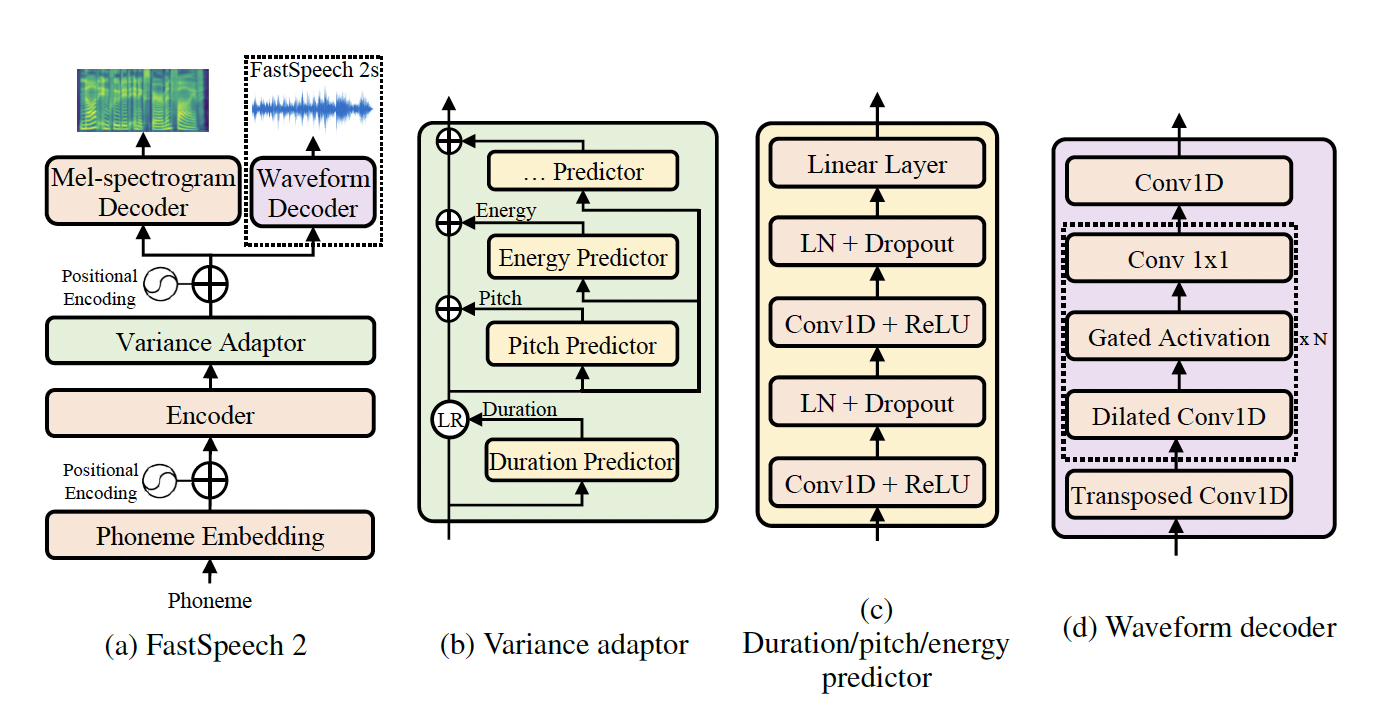

In [2]:
Image(filename = "../references/images/fastspeech2_model.png", width=1000, height=500)

## Duration/Pitch/Energy Predictor

Let's take: <br>
- `batch_size`: 4<br>
- `hidden_dimension`: 386<br>
- `phoneme/token sequence length`: 32 (n)<br>
- `mel-spectrogram/pitch/energy sequence length`: 380 (m)<br>

n = {n1, n2, n3, ... n32} <br>
m = n1 + n2 + n3 + ... + n32 <br>
Length regulator will expand the input frames of phoneme/token sequence. For length regulator input will be the output of `Encoder` with shape (batch x seq_len x emb_dim) and predicted value of `Duration Predictor` layer. Based on values coming from duration predictor, this will expand the output sequence of `Encoder`.



## Inputs

- `Token Embedding`: (Batch x Sequence Length x Embedding)

In [3]:
# ! pip list | grep numpy
# ! pip uninstall numpy torch torchvision torchaudio
# ! pip list | grep torch

In [4]:
import os
import yaml
import torch
import numpy as np
import torch.nn as nn
from pathlib import Path
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
FEATURE_DIR = Path(os.getcwd()).parent / 'data' / 'processed' / 'lj_speech_feature'
! ls $FEATURE_DIR

duration energy   mel_spec pitch


In [6]:
from audioml.processing.text_speech_alignment import TTSTokenizer
from audioml.dataset.feature_dataset import SpeechFeatureDataset, collate_function

W0607 13:13:57.247000 42764 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [7]:
feature_dataset = SpeechFeatureDataset(
    feature_dir=FEATURE_DIR
)

[NeMo I 2025-06-07 13:13:59 nemo_logging:393] Found existing object /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo.
[NeMo I 2025-06-07 13:13:59 nemo_logging:393] Re-using file from: /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo
[NeMo I 2025-06-07 13:13:59 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2025-06-07 13:14:12 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-06-07 13:14:12 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /data3/LJSpeech/nvidia_ljspeech_train.json
      sample_rate: 22050
      sup_data_path: /data3/LJSpeech/align_supplementary/
      sup_data_types:
      - align_prior_matrix
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      low

[NeMo I 2025-06-07 13:14:12 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-07 13:14:12 nemo_logging:393] Model AlignerModel was successfully restored from /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo.


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.


In [8]:
# print(feature_dataset[0])
print(f"Length of dataset: {len(feature_dataset)}")
feature = feature_dataset[0]
print(feature.keys())
fname = feature['filename']
mel_spectrogram = feature['mel_spectrogram']
energy = feature['energy']
duration = feature['duration']
pitch_contour = feature['pitch_contour']
pitch_contour_mean = feature['pitch_contour_mean']
pitch_contour_std = feature['pitch_contour_std']
pitch_spectrogram = feature['pitch_spectrogram']
print(f"fname: {fname}")
print(f"mel shape: {mel_spectrogram.shape}")
print(f"energy shape: {energy.shape}")
print(f"duration shape: {duration.shape} & Duration sum: {sum(duration)}")
print(f"pitch contour shape: {pitch_contour.shape}")
print(f"pitch contour mean: {pitch_contour_mean}")
print(f"pitch contour std: {pitch_contour_std}")
print(f"pitch spectrogram shape: {pitch_spectrogram.shape}")


batch_size = 8
shuffle=True
feature_dataloader = DataLoader(
    feature_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    collate_fn=collate_function
)

Length of dataset: 13084
dict_keys(['filename', 'raw_text', 'token_ids', 'mel_spectrogram', 'energy', 'duration', 'pitch_contour', 'pitch_contour_mean', 'pitch_contour_std', 'pitch_spectrogram'])
fname: LJ007-0106
mel shape: torch.Size([715, 128])
energy shape: torch.Size([715])
duration shape: torch.Size([128]) & Duration sum: 715.0
pitch contour shape: torch.Size([715])
pitch contour mean: 5.309299945831299
pitch contour std: 0.2519161105155945
pitch spectrogram shape: torch.Size([715, 10])


In [9]:
# np.load(str(FEATURE_DIR / "pitch" / "pitch_contour_mean_LJ008-0173.npy"))
# np.load(str(FEATURE_DIR / "pitch" / "pitch_contour_mean_LJ015-0052.npy"))
# np.load(str(FEATURE_DIR / "pitch" / "pitch_contour_LJ014-0049.npy"))

In [10]:
for batch in feature_dataloader:
    print(batch)
    break        

Max sizes of features in batch:
Mel Spectrogram max length: 660
Energy max length: 660
Duration max length: 95
Pitch Spectrogram max length: 660
Pitch contour max length: 660
{'filename': ['LJ044-0117', 'LJ018-0298', 'LJ041-0047', 'LJ019-0174', 'LJ009-0081', 'LJ017-0209', 'LJ035-0196', 'LJ026-0127'], 'raw_text': ['that there were people who understood his activity, end quote.', 'Time was clearly an important factor in the fraud, hence the bills were sent forward in quick succession.', 'approximately three years before. Robert Oswald had given his Marine Corps manual to his brother Lee,', 'It was less prompt apparently in dealing with structural alterations and improvements.', 'For a while the preacher addresses himself to the congregation at large, who listen attentively', 'more particularly as regards locomotion.', 'The address listed was for the Paine home in Irving.', 'These processes must take place everywhere in ordinary protoplasm,'], 'token_ids': tensor([[ 0, 89, 77, 70, 89,  0,

In [11]:
batch.keys()

dict_keys(['filename', 'raw_text', 'token_ids', 'token_length', 'token_max_length', 'mel_spectrogram', 'mel_length', 'mel_max_length', 'energy', 'energy_length', 'energy_max_length', 'duration', 'duration_length', 'duration_max_length', 'pitch_contour', 'pitch_contour_length', 'pitch_contour_max_length', 'pitch_contour_mean', 'pitch_contour_std', 'pitch_spectrogram', 'pitch_spectrogram_length', 'pitch_spectrogram_max_length'])

In [12]:
batch['pitch_contour_mean']

[tensor(5.0445),
 tensor(5.2952),
 tensor(5.3176),
 tensor(5.2743),
 tensor(5.4028),
 tensor(5.3884),
 tensor(5.4220),
 tensor(5.3546)]

In [13]:
batch_path = Path(os.getcwd()).parent / 'audioml' / 'temp_batch.pt'
feature_batch = torch.load(batch_path)

In [14]:
feature_batch.keys()

dict_keys(['filename', 'raw_text', 'token_ids', 'token_length', 'token_max_length', 'mel_spectrogram', 'mel_length', 'mel_max_length', 'energy', 'energy_length', 'energy_max_length', 'duration', 'duration_length', 'duration_max_length', 'pitch_contour', 'pitch_contour_length', 'pitch_contour_max_length', 'pitch_contour_mean', 'pitch_contour_std', 'pitch_spectrogram', 'pitch_spectrogram_length', 'pitch_spectrogram_max_length'])

### Features
1. filename
2. raw_text
3. token_ids
4. token_length
5. token_max_length
6. mel_spectrogram
7. mel_length
8. mel_max_length
9. energy
10. elergy_length
11. energy_max_length
12. duration
13. duration_length
14. duration_max_length
15. pitch_contour
16. pitch_contour_length
17. pitch_contour_max_length
18. pitch_contour_mean
19. pitch_contour_std
20. pitch_spectrogram
21. pitch_spectrogram_length
22. pitch_spectrogram_max_length

### Feature Checks

In [15]:
feature_batch['raw_text']

['Communications in the motorcade.',
 'But I shall ask both groups to give a fair trial to peaceful methods of adjusting their conflicts of opinion and interest,',
 'Lee Harvey Oswald: Background and Possible Motives, Part five.',
 'The entrance fee was at least thirteen shillings, six pence a head, with half-a-crown a week more for bed and bedding,',
 'In that connection, it should be noted that Marina Oswald testified on September six, nineteen sixty-four, that she thought her husband, quote,',
 'He asked his wife to help him to hijack an airplane to get there, but gave up that scheme when she refused.',
 'they preferred to credit it to carelessness or collusion from officers of the jail.',
 'As a political leader, the President wished to resolve the factional controversy within the Democratic Party in Texas before the election of nineteen sixty-four.']

In [16]:
feature_batch['token_ids'].shape, feature_batch['token_length'], feature_batch['token_max_length']

(torch.Size([8, 154]), [31, 111, 57, 105, 129, 99, 77, 154], 154)

In [17]:
feature_batch['duration'].shape, feature_batch['duration_length'], feature_batch['duration_max_length']

(torch.Size([8, 154]), [31, 111, 57, 105, 129, 99, 77, 154], 154)

In [18]:
feature_batch['pitch_contour'].shape, feature_batch['pitch_contour_length'], feature_batch['pitch_contour_max_length']

(torch.Size([8, 837]), [156, 805, 453, 653, 820, 599, 441, 837], 837)

In [19]:
torch.sum(feature_batch['duration'], axis=1)

tensor([156., 805., 453., 653., 820., 599., 441., 837.])

In [20]:
feature_batch['duration']

tensor([[ 2.,  4.,  6.,  ...,  0.,  0.,  0.],
        [ 1.,  4.,  8.,  ...,  0.,  0.,  0.],
        [ 3.,  5., 10.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  3.,  5.,  ...,  0.,  0.,  0.],
        [23.,  4.,  5.,  ...,  0.,  0.,  0.],
        [ 3.,  7.,  4.,  ...,  5., 10.,  7.]])

In [21]:
# Creating mel_mask from duration feature
mel_feature_length = torch.sum(feature_batch['duration'], axis=1, dtype=torch.int)
mel_feature_length

tensor([156, 805, 453, 653, 820, 599, 441, 837], dtype=torch.int32)

In [22]:
def get_mask_from_lengths(lengths, max_len=None):
    batch_size = lengths.shape[0]
    if max_len is None:
        max_len = torch.max(lengths).item()

    ids = torch.arange(0, max_len).unsqueeze(0).expand(batch_size, -1)
    mask = ids >= lengths.unsqueeze(1).expand(-1, max_len)

    return mask

## Attention Mask

In [23]:
token_lengths = torch.tensor(feature_batch['token_length'], dtype=torch.int16)
print(token_lengths.shape)

token_mask = get_mask_from_lengths(lengths=token_lengths)
print(token_mask.shape)

torch.Size([8])
torch.Size([8, 154])


In [24]:
# Column Masking
col_token_mask = token_mask.unsqueeze(1).expand(-1, token_mask.shape[1], -1)
row_token_mask = token_mask.unsqueeze(2).expand(-1, -1, token_mask.shape[1])

In [25]:
mask = (row_token_mask & col_token_mask)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [

In [26]:
mask.shape # --> (batch x seq_len x seq_len)

torch.Size([8, 154, 154])

## Attention

In [27]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_in, d_out, n_head, dropout=0.5, qkv_bias=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.n_head = n_head
        self.head_dim = self.d_out // self.n_head

        assert self.head_dim * self.n_head == self.d_out, "Head dimension is not matching with model dimension"

        # Key, Query and Value projection
        self.w_k = nn.Linear(self.d_in, self.d_out, bias=qkv_bias)
        self.w_q = nn.Linear(self.d_in, self.d_out, bias=qkv_bias)
        self.w_v = nn.Linear(self.d_in, self.d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)
        self.w_o = nn.Linear(self.d_out, self.d_out, bias=True)

    def forward(self, x, mask=None):
        batch, seq_len, emb_dim = x.shape[0], x.shape[1], x.shape[2] # Here sequene length will be the padded sequence length
        # print(f"batch: {batch} | seq_len: {seq_len} | emb_dim: {emb_dim}")
        key = self.w_k(x).view(batch, seq_len, self.n_head, self.head_dim).transpose(1, 2) # (batch, seq_len, d_in) --> (batch, n_head, seq_len, head_dim)
        query = self.w_q(x).view(batch, seq_len, self.n_head, self.head_dim).transpose(1, 2) # (batch, seq_len, d_in) --> (batch, n_head, seq_len, head_dim)
        value = self.w_v(x).view(batch, seq_len, self.n_head, self.head_dim).transpose(1, 2) # (batch, seq_len, d_in) --> (batch, n_head, seq_len, head_dim)
        # print(f"Shape | key: {key.shape}, query: {query.shape}, value: {value.shape}")
        attn_scores = query @ key.transpose(2, 3) # --> (batch, n_head, seq_len, head_dim) * (batch, n_head, head_dim, seq_len) = (batch, n_head, seq_len, seq_len)
        # attn_scores = torch.bmm(query, key.transpose(2, 3)) 

        if mask != None:
            # Mask Calculation
            # Column Masking mask --> (batch x seq_len)
            seq_len = mask.shape[-1]
            assert seq_len == attn_scores.shape[-1], "Mask sequence length is NOT equal to attention scores"
            col_token_mask = mask.unsqueeze(1).expand(-1, seq_len, -1) # --> (batch x seq_len x seq_len)
            row_token_mask = mask.unsqueeze(2).expand(-1, -1, seq_len) # --> (batch x seq_len x seq_len)
            mask = col_token_mask & row_token_mask # --> (batch x seq_len x seq_len)
            mask = mask.unsqueeze(1).expand(-1, self.n_head, -1, -1).bool() # --> (batch x n_head x seq_len x seq_len)
            attn_scores = attn_scores.masked_fill(mask, -float('inf'))# --> (batch x n_head x seq_len x seq_len)

        attn_weights = torch.softmax(
            attn_scores / key.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ value # --> (batch x n_head x seq_len x head_dim)
        # context_vec = torch.bmm(attn_weights, value).transpose(1, 2) 
        context_vec = context_vec.transpose(1, 2).contiguous().view(
            batch, seq_len, self.d_out
        )

        context_vec = self.w_o(context_vec)
        return context_vec

In [28]:
class Embedding(nn.Module):

    def __init__(self, emb_dim, vocab_size, token_context_length):
        super().__init__()
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size
        self.context_length = token_context_length

        self.tok_emb = nn.Embedding(self.vocab_size, self.emb_dim)
        self.pos_emb = nn.Embedding(self.context_length, self.emb_dim)

    def forward(self, x):
        batch, seq_len = x.shape
        emb = self.tok_emb(x)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len) # Add this tensor to device with argument device
        )
        embedding = emb + pos_embeds
        return embedding

In [29]:
embedding_config = {
    'emb_dim': 384,
    'vocab_size': 114,
    'token_context_length': 512
}
embedding_layer = Embedding(
    emb_dim=embedding_config['emb_dim'],
    vocab_size=embedding_config['vocab_size'],
    token_context_length=embedding_config['token_context_length']
)

In [30]:
input_token_ids = feature_batch['token_ids']
print(input_token_ids.shape)

torch.Size([8, 154])


In [31]:
class Conv1D(nn.Module):

    def __init__(self, emb_dim, kernel_size=3, stride=1, padding=None, dilation=1):
        super().__init__()
        if padding is None:
            assert kernel_size % 2 == 1
            padding = int(dilation * (kernel_size - 1) / 2)
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=emb_dim, out_channels=4*emb_dim, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.Conv1d(in_channels=4*emb_dim, out_channels=emb_dim, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        )
    
    def forward(self, x):
        return self.layers(x).transpose(1, 2)

class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

## FFT Block

In [32]:
class FFTBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        # MHA Layer params
        self.d_in = cfg['d_in']
        self.d_out = cfg['d_out']
        self.n_head = cfg['n_head']
        self.dropout = cfg['drop_rate']
        self.qkv_bias = cfg['qkv_bias']

        self.mha = MultiHeadAttention(
            d_in=self.d_in,
            d_out=self.d_out,
            n_head=self.n_head,
            dropout=self.dropout,
            qkv_bias=self.qkv_bias
        )
        self.layer_norm1 = LayerNorm(
            emb_dim=self.d_out
        )

        self.conv1d = Conv1D(
            emb_dim=self.d_out,
            kernel_size=cfg['kernel_size'],
            stride=cfg['stride'],
            padding=cfg['padding'],
            dilation=cfg['dilation']
        )
        self.layer_norm2 = LayerNorm(
            emb_dim=self.d_out
        )
        self.dropout = nn.Dropout(self.dropout)
        

    def forward(self, x, mask): # --> (batch x seq_len x d_in)
        
        residual = x
        x = self.layer_norm1(x)
        x = self.mha(x, mask)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.conv1d(x.transpose(1, 2))
        x = self.dropout(x)
        x = x + residual
        
        return x

In [33]:
fft_cfg = {
    'd_in': 384,
    'd_out': 384,
    'n_head': 2,
    'drop_rate': 0.1,
    'qkv_bias': False,
    'kernel_size': 3,
    'stride': 1,
    'padding': None,
    'dilation': 1
}

fft_layer = FFTBlock(
    cfg=fft_cfg    
)

In [34]:
print(f"Input Shape: {input_token_ids.shape}")
emb = embedding_layer(input_token_ids)
print(f"Embedding Shape: {emb.shape}")
# encoder_output = fft_layer(emb)
# print(f"Encoder output shape: {encoder_output.shape}")

Input Shape: torch.Size([8, 154])
Embedding Shape: torch.Size([8, 154, 384])


## Encoder

In [35]:
class Encoder(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.n_fft_layers = cfg['n_fft_layers']
        self.fft_cfg = cfg['fft']
        self.embedding_config = cfg['embedding_layer']
        self.text_config = cfg['text']
        # Embedding Layer
        self.embedding_layer = Embedding(
            emb_dim=self.embedding_config['dims'],
            vocab_size=self.text_config['vocab_size'],
            token_context_length=self.embedding_config['context_length']
        )

        # FFT Block
        self.fft_layers = nn.ModuleList(
            [
                FFTBlock(cfg=self.fft_cfg) for _ in range(self.n_fft_layers)
            ]
        )

    def forward(self, input_ids, mask):
        fft_output = self.embedding_layer(input_ids)
        for fft in self.fft_layers:
            fft_output = fft(fft_output, mask)

        return fft_output

### Config

In [36]:
os.listdir(Path(os.getcwd()).parent / 'audioml')
config_path = Path(os.getcwd()).parent / 'audioml' / 'config.yaml'
print(config_path)

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

/Users/mayankanand/Documents/audio/audio/audioml/config.yaml


In [37]:
tokenizer = TTSTokenizer()

[NeMo I 2025-06-07 13:14:28 nemo_logging:393] Found existing object /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo.
[NeMo I 2025-06-07 13:14:28 nemo_logging:393] Re-using file from: /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo
[NeMo I 2025-06-07 13:14:28 nemo_logging:393] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2025-06-07 13:14:41 nemo_logging:405] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-06-07 13:14:41 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /data3/LJSpeech/nvidia_ljspeech_train.json
      sample_rate: 22050
      sup_data_path: /data3/LJSpeech/align_supplementary/
      sup_data_types:
      - align_prior_matrix
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      low

[NeMo I 2025-06-07 13:14:41 nemo_logging:393] PADDING: 1
[NeMo I 2025-06-07 13:14:41 nemo_logging:393] Model AlignerModel was successfully restored from /Users/mayankanand/.cache/torch/NeMo/NeMo_2.3.1/Aligner/5b0d70eb6a09c1a8470b745034a1a00b/Aligner.nemo.


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.


In [38]:
encoder_config = config['encoder']
encoder = Encoder(encoder_config)

In [39]:
feature_batch['raw_text']

['Communications in the motorcade.',
 'But I shall ask both groups to give a fair trial to peaceful methods of adjusting their conflicts of opinion and interest,',
 'Lee Harvey Oswald: Background and Possible Motives, Part five.',
 'The entrance fee was at least thirteen shillings, six pence a head, with half-a-crown a week more for bed and bedding,',
 'In that connection, it should be noted that Marina Oswald testified on September six, nineteen sixty-four, that she thought her husband, quote,',
 'He asked his wife to help him to hijack an airplane to get there, but gave up that scheme when she refused.',
 'they preferred to credit it to carelessness or collusion from officers of the jail.',
 'As a political leader, the President wished to resolve the factional controversy within the Democratic Party in Texas before the election of nineteen sixty-four.']

In [40]:
text_batch = feature_batch['raw_text']

input_ids = tokenizer.batch_tokenize(text_batch)

encoder_output = encoder(input_ids['input_ids'], input_ids['mask_ids'])

In [41]:
encoder_output.shape

torch.Size([8, 154, 384])

In [42]:
token_length = torch.tensor(feature_batch['token_length'])
max_token_length = torch.max(token_length)

src_mask = (torch.arange(start=0, end=max_token_length) >= token_length.unsqueeze(-1)).int()

## Duration Predictor

In [43]:
class TransposedLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super().__init__()
        self.ln = nn.LayerNorm(normalized_shape)
        
    def forward(self, x):
        x = x.transpose(1, 2)  # [B, C, T] -> [B, T, C]
        x = self.ln(x)
        x = x.transpose(1, 2)  # [B, T, C] -> [B, C, T]
        return x

In [44]:
class DurationPredictor(nn.Module):

    def __init__(self, input_size, filter_size=384, num_layers=2, kernel_size=3, stride=1, dropout_rate=0.1):
        super().__init__()
        
        # Convolutional layers for pitch prediction
        self.convolutions = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size if i == 0 else filter_size, 
                    out_channels=filter_size,
                    kernel_size=kernel_size,
                    padding=(kernel_size - 1) // 2
                ),
                TransposedLayerNorm(filter_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ) for i in range(num_layers)
        ]) # --> (batch x in_channel x sequence_length) = (batch x filter_size x sequence_length)

        self.linear_proj = nn.Linear(filter_size, 1)

    
    def forward(self, x, mask):
        # Transpose for convolution (channel first)
        x = x.transpose(1, 2) # --> (batch x sequence_length x emb_dim) = (batch x emb_dim x sequence_length)
        
        # Pass through convolutional layers
        for conv_layer in self.convolutions: # --> (batch x emb_dim x sequence_length) = (batch x filter_size x sequence_length)
            conv, layerNorm, relu, dropout = conv_layer

            x = conv(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = layerNorm(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = relu(x)
            x = dropout(x)
        
        x = x.transpose(1, 2) # --> (batch x filter_size x sequence_length) = (batch x sequence_length x filter_size)

        log_duration = self.linear_proj(x).squeeze() # --> (batch x seq_length x filter_size) = (batch x seq_length)
        
        return log_duration

In [45]:
duration_predictor = DurationPredictor(input_size=384)
log_duration = duration_predictor(encoder_output, src_mask)
print(f"Log Duration Shape: {log_duration.shape}")

Log Duration Shape: torch.Size([8, 154])


In [46]:
# While calculating predicted duration value from log_duration, it is important to clamp the values 
# with minimum value of 1. Then masking will be applied to the padded values.
# These operations should take place inside VarianceAdaptor
torch.round(torch.exp(log_duration))

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.]], grad_fn=<RoundBackward0>)

## Length Regulator

In [47]:
class LengthRegulator(nn.Module):

    def __init__(self):
        super(LengthRegulator, self).__init__()

    def LR(self, x, duration):
        """
        x --> (batch_size, sequence_length, embedding_size)
        duration --> (batch_size, max_sequence_length) ==> 2D tensor at phone sequence level
        For Training: Ground truth duration will be used
        For Inference: Predicted duration will be used
        """
        output = list()
        mel_len = list()

        for phon_embedding, phon_duration in zip(x, duration):
            """
            phon_embedding --> (phon_sequence, embedding_size)
            phon_duration --> (max_sequence_length)
            """
            expanded_embedding = self._expand(phon_embedding, phon_duration)
            output.append(expanded_embedding)
            mel_len.append(expanded_embedding.shape[0])

        mel_len = torch.tensor(mel_len)
        max_mel_len = torch.max(mel_len)
        # Padding of expanded phoneme --> mel_embedding
        padded_mel_embedding = list()
        for idx, expanded in enumerate(output):
            padded_mel_embedding.append(
                F.pad(
                    expanded,
                    (0, 0, 0, max_mel_len - mel_len[idx]),
                    'constant',
                    0
                )
            )
        phon_expanded_embedding = torch.stack(padded_mel_embedding, dim=0)
        # Logic for mel_mask
        mel_mask = (torch.arange(start=0, end=max_mel_len) >= mel_len.unsqueeze(-1)).int()
        return phon_expanded_embedding, mel_mask
        

    def _expand(self, phon_embedding, phon_duration):
        out = list()
        for idx, vec in enumerate(phon_embedding):
            expand_size = phon_duration[idx].item()
            out.append(vec.expand(max(int(expand_size), 0), -1))

        return torch.cat(out, 0)

    def forward(self, x, duration):
        mel_embedding, mel_mask = self.LR(x, duration)
        return mel_embedding, mel_mask

In [48]:
lr = LengthRegulator()

encoder_expanded_output, mel_mask = lr.LR(encoder_output, feature_batch['duration'])

In [49]:
print(f"Expanded Mel Decoder Input Shape: {encoder_expanded_output.shape}")
print(f"Mel Mask: {mel_mask.shape}")

Expanded Mel Decoder Input Shape: torch.Size([8, 837, 384])
Mel Mask: torch.Size([8, 837])


## Pitch Predictor

In [50]:
class PitchPredictor(nn.Module):
    def __init__(
        self, 
        input_size, 
        filter_size=384, 
        kernel_size=3, 
        dropout_rate=0.1, 
        num_layers=2,
        cwt_scales=10,  # Number of CWT scales in pitch spectrogram
        pitch_bins=256,
        pitch_embeddings=384
    ):
        """
        Pitch Predictor for FastSpeech2
        
        Args:
            input_size (int): Size of input encoder representations --> 384
            filter_size (int): Hidden layer size for predictor --> 384
            kernel_size (int): Convolution kernel size --> 3
            dropout_rate (float): Dropout probability --> 0.1
            num_layers (int): Number of convolutional layers --> 2
            cwt_scales (int): Number of scales in pitch spectrogram --> 10
        """
        super(PitchPredictor, self).__init__()
        
        # Convolutional layers for pitch prediction
        self.convolutions = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size if i == 0 else filter_size, 
                    out_channels=filter_size,
                    kernel_size=kernel_size,
                    padding=(kernel_size - 1) // 2
                ),
                TransposedLayerNorm(filter_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ) for i in range(num_layers)
        ]) # --> (batch x in_channel x sequence_length) = (batch x filter_size x sequence_length)

        
        self.pitch_spectrogram_head = nn.Linear(
            filter_size,
            cwt_scales
        ) # (batch x seqence_length x filter_size) --> (batch x seqence_length x cwt_scale)

        self.stats_projection = nn.Linear(filter_size, 2) # --> (batch x filter_size) = (batch x 2)

        self.pitch_embedding = nn.Embedding(pitch_bins, pitch_embeddings)

        self.register_buffer(
            "icwt_weights",
            (torch.arange(cwt_scales) + 2.5)**(-2.5)
        ) # --> (cwt_scales, )
        
    def forward(self, encoder_output, mask): # --> encoder_output: (batch x sequence_length x embedding_dimension)
        """
        Forward pass for pitch prediction
        
        Args:
            encoder_output (torch.Tensor): Encoder representations
                Shape: [batch_size, sequence_length, input_size]
        
        Returns:
            dict: 
                - pitch_spectrogram: Predicted pitch spectrogram
                - pitch_mean: Predicted pitch mean
                - pitch_std: Predicted pitch standard deviation
        """
        batch, seq_len, emb_dim = encoder_output.shape
        
        # Transpose for convolution (channel first)
        x = encoder_output.transpose(1, 2) # --> (batch x sequence_length x emb_dim) = (batch x emb_dim x sequence_length)
        
        # Pass through convolutional layers
        for conv_layer in self.convolutions: # --> (batch x emb_dim x sequence_length) = (batch x filter_size x sequence_length)
            conv, layerNorm, relu, dropout = conv_layer

            x = conv(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = layerNorm(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = relu(x)
            x = dropout(x)
        
        # Predict pitch spectrogram
        x = x.transpose(1, 2) # --> (batch x fiter_size x sequence_length) = (batch x sequence_length x filter_size)
        pitch_spectrogram = self.pitch_spectrogram_head(x) # --> (batch x sequence_length x filter_size) = (batch x sequence_length x cwt_scale)
        pitch_spectrogram = pitch_spectrogram.masked_fill(mask.unsqueeze(-1).bool(), 0)
        
        # Predict pitch mean and std
        global_vector = torch.mean(x, dim=1) # --> (batch x sequence_length x filter_size) = (batch x filter_size)
        pitch_stats = self.stats_projection(global_vector) # --> (batch x filter_size) = (batch x  2)

        pitch_mean = pitch_stats[:, 0]
        pitch_std = pitch_stats[:, 1] # Standard deviation should have positivity constraint
        pitch_std = torch.exp(pitch_std) ** 0.5 # Positivity constraint

        # Reconstructing pitch contour
        weights = self.icwt_weights.unsqueeze(0).expand(seq_len, -1) # --> (sequence_length x cwt_scale)
        f0_norm = torch.sum(pitch_spectrogram * weights, dim=-1)
        f0 = (f0_norm * pitch_std.unsqueeze(1).expand(-1, seq_len)) + pitch_mean.unsqueeze(1).expand(-1, seq_len)
        f0 = f0.masked_fill(mask.bool(), 0)

        # Pitch quantization
        f0_min = torch.min(f0, dim=-1, keepdim=True).values
        f0_max = torch.max(f0, dim=-1, keepdim=True).values
        bins = (f0_max - f0_min) / 256

        quantized_pitch = torch.floor((f0 - f0_min) / bins).clamp(0, 255).to(torch.int32)
        quantized_pitch = quantized_pitch.masked_fill(mask.bool(), 0)
        
        pitch_embedding = self.pitch_embedding(quantized_pitch)
        pitch_embedding = pitch_embedding.masked_fill(mask.unsqueeze(-1).bool(), 0)

        
        return {
            'pitch_spectrogram': pitch_spectrogram,
            'pitch_mean': pitch_mean,
            'pitch_std': pitch_std,
            'reconstructed_f0': f0,
            'pitch_embedding': pitch_embedding
        }

In [51]:
pitch_predictor = PitchPredictor(
    input_size=384,
    filter_size=384,
    kernel_size=3,
    dropout_rate=0.1,
    num_layers=2,
    cwt_scales=10
)

In [52]:
pitch_output = pitch_predictor(encoder_expanded_output, mel_mask)
pitch_output.keys()

dict_keys(['pitch_spectrogram', 'pitch_mean', 'pitch_std', 'reconstructed_f0', 'pitch_embedding'])

In [53]:
print(f"Pitch features shapes:")
print(f"pitch spectrogram: {pitch_output['pitch_spectrogram'].shape}")
print(f"pitch mean: {pitch_output['pitch_mean'].shape}"), 
print(f"pitch std: {pitch_output['pitch_std'].shape}")
print(f"pitch contour: {pitch_output['reconstructed_f0'].shape}")
print(f"pitch embedding: {pitch_output['pitch_embedding'].shape}")

Pitch features shapes:
pitch spectrogram: torch.Size([8, 837, 10])
pitch mean: torch.Size([8])
pitch std: torch.Size([8])
pitch contour: torch.Size([8, 837])
pitch embedding: torch.Size([8, 837, 384])


In [54]:
print(f"Pitch Ground Truth Shapes:")
print(f"Pitch contour: {feature_batch['pitch_contour'].shape}")
print(f"Pitch spectrogram: {feature_batch['pitch_spectrogram'].shape}")

Pitch Ground Truth Shapes:
Pitch contour: torch.Size([8, 837])
Pitch spectrogram: torch.Size([8, 837, 10])


In [55]:
# Input for pitch predictor: Expanded form of encoder output which comes after length regulator
# Pitch, Energy and Mel-Spectrogram comes with audio time frames
# Duration bridges the phoneme time frames and Pitch/Energy/Mel-Spectrogram time frames

## Energy Predictor

In [56]:
class EnergyPredictor(nn.Module):

    def __init__(self, 
                 input_size, 
                 filter_size=384, 
                 num_layers=2, 
                 kernel_size=3, 
                 stride=1, 
                 dropout_rate=0.1, 
                 energy_bins=256, 
                 energy_embedding=384):
        super().__init__()
        
        # Convolutional layers for pitch prediction
        self.convolutions = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels=input_size if i == 0 else filter_size, 
                    out_channels=filter_size,
                    kernel_size=kernel_size,
                    padding=(kernel_size - 1) // 2
                ),
                TransposedLayerNorm(filter_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ) for i in range(num_layers)
        ]) # --> (batch x in_channel x sequence_length) = (batch x filter_size x sequence_length)

        self.linear_proj = nn.Linear(filter_size, 1)
        self.energy_embedding = nn.Embedding(energy_bins, energy_embedding) # --> (batch x sequence_length) = (batch x sequence_length x energy_embedding)

    def forward(self, x, mask):
        # Transpose for convolution (channel first)
        x = x.transpose(1, 2) # --> (batch x sequence_length x emb_dim) = (batch x emb_dim x sequence_length)
        
        # Pass through convolutional layers
        for conv_layer in self.convolutions: # --> (batch x emb_dim x sequence_length) = (batch x filter_size x sequence_length)
            conv, layerNorm, relu, dropout = conv_layer

            x = conv(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = layerNorm(x)
            x = x.masked_fill(mask.unsqueeze(1).bool(), 0)

            x = relu(x)
            x = dropout(x)
        
        x = x.transpose(1, 2) # --> (batch x filter_size x sequence_length) = (batch x sequence_length x filter_size)

        energy_pred = self.linear_proj(x).squeeze() # --> (batch x sequence_length x filter_size) = (batch x sequence_length x 1)
        energy_pred = energy_pred.masked_fill(mask.bool(), 0)

        # Energy Quantization
        energy_min = torch.min(energy_pred, dim=-1, keepdim=True).values
        energy_max = torch.max(energy_pred, dim=-1, keepdim=True).values
        bins = (energy_max - energy_min) / 256

        quantized_energy = torch.floor((energy_pred - energy_min) / bins).clamp(0, 255).to(torch.int32)
        quantized_energy = quantized_energy.masked_fill(mask.bool(), 0)

        
        energy_embedding = self.energy_embedding(quantized_energy)
        energy_embedding = energy_embedding.masked_fill(mask.unsqueeze(-1).bool(), 0)
        
        return {
            'raw_energy': energy_pred,
            'quantized_energy': quantized_energy,
            'energy_embedding': energy_embedding
        }

In [57]:
energy_predictor = EnergyPredictor(
    input_size=384
)

In [58]:
energy_pred = energy_predictor(encoder_expanded_output, mel_mask)

In [59]:
energy_pred.keys()

dict_keys(['raw_energy', 'quantized_energy', 'energy_embedding'])

In [60]:
energy_pred['raw_energy'].shape, energy_pred['quantized_energy'].shape, energy_pred['energy_embedding'].shape

(torch.Size([8, 837]), torch.Size([8, 837]), torch.Size([8, 837, 384]))

In [61]:
energy_pred['raw_energy']

tensor([[ 0.0742, -0.5139,  0.0152,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3857,  0.3286,  0.5157,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0161, -0.3006, -0.4728,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.6656, -0.6126, -0.1419,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2400, -0.3122, -0.2645,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1721, -0.2300, -0.6515,  ..., -0.3526, -0.4179, -0.1657]],
       grad_fn=<MaskedFillBackward0>)

## Variance Adaptor

In [62]:
class VarianceAdaptor(nn.Module):

    def __init__(self, 
                 input_size, 
                 filter_size=384, 
                 num_layers=2, 
                 kernel_size=3, 
                 stride=1, 
                 dropout_rate=0.1, 
                 cwt_scales=10):
        super().__init__()
        
        # Duration Predictor
        self.duration_predictor = DurationPredictor(
            input_size=input_size,
            filter_size=filter_size,
            num_layers=num_layers,
            kernel_size=kernel_size,
            stride=stride
        )

        # Length Regulator
        self.lr = LengthRegulator()
        
        # Pitch Predictor
        self.pitch_predictor = PitchPredictor(
            input_size=input_size,
            filter_size=filter_size,
            kernel_size=kernel_size,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            cwt_scales=cwt_scales
        )

        # Energy Predictor
        self.energy_predictor = EnergyPredictor(
            input_size=input_size,
            filter_size=filter_size,
            kernel_size=kernel_size,
            dropout_rate=dropout_rate,
            num_layers=num_layers,
            stride=stride
        )


    def forward(self, x, src_mask, alpha=1.0, train=False, gt_duration=None):

        # Different input duration according to training or inference
        # Duration Prediction
        log_duration = self.duration_predictor(x, src_mask)

        # Processing on log_duration
        duration = torch.exp(log_duration) * alpha
        
        # Round to nearest integer and convert to int
        duration = torch.round(duration).squeeze(-1).long()
    
        # Ensure minimum duration of 1
        duration = torch.clamp_min(duration, 1)
        duration = duration.masked_fill(src_mask.bool(), 0)

        if train:
            if gt_duration == None:
                raise ValueError("Ground Truth of duration must pass in training mode.")
            
            # Length Regulator
            mel_hidden_state, mel_mask = self.lr(x, gt_duration)
        else:
            # Length Regulator
            mel_hidden_state, mel_mask = self.lr(x, duration)
    
        # Adding pitch prediction
        residual = mel_hidden_state
        pitch_output = self.pitch_predictor(mel_hidden_state, mel_mask)
        mel_hidden_state = pitch_output['pitch_embedding']
        mel_hidden_state = mel_hidden_state + residual

        # Adding Energy prediction
        residual = mel_hidden_state
        energy_output = self.energy_predictor(mel_hidden_state, mel_mask)
        mel_hidden_state = energy_output['energy_embedding']
        mel_hidden_state = mel_hidden_state + residual

        return mel_hidden_state, mel_mask, duration, pitch_output, energy_output

In [63]:
va = VarianceAdaptor(input_size=384)

In [64]:
mel_hidden_state, mel_mask, duration, pitch_output, energy_output = va(
    encoder_output, 
    src_mask, 
    train=True, 
    gt_duration=feature_batch['duration']
)

## Mel Decoder

In [65]:
# Input: (batch x seq_length x emb_dimension)
class MelDecoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.n_fft_layers = cfg['n_fft_layers']
        self.fft_cfg = cfg['fft']
        self.d_out = self.fft_cfg['d_out']
        self.n_mels = cfg['n_mels']

        # FFT Block
        self.fft_layers = nn.ModuleList(
            [
                FFTBlock(cfg=self.fft_cfg) for _ in range(self.n_fft_layers)
            ]
        )

        self.mel_proj = nn.Linear(self.d_out, self.n_mels)
        

    def forward(self, x, mask): # --> (batch x seq_len x d_in)
    
        for fft in self.fft_layers:
            x = fft(x, mask)

        mel_spec = self.mel_proj(x)
        mel_spec = mel_spec.masked_fill(mask.unsqueeze(-1).bool(), 0)
        return mel_spec

In [66]:
mel_decoder = MelDecoder(config['decoder'])

In [67]:
mel_spec = mel_decoder(mel_hidden_state, mel_mask)

In [68]:
mel_spec.shape

torch.Size([8, 837, 128])

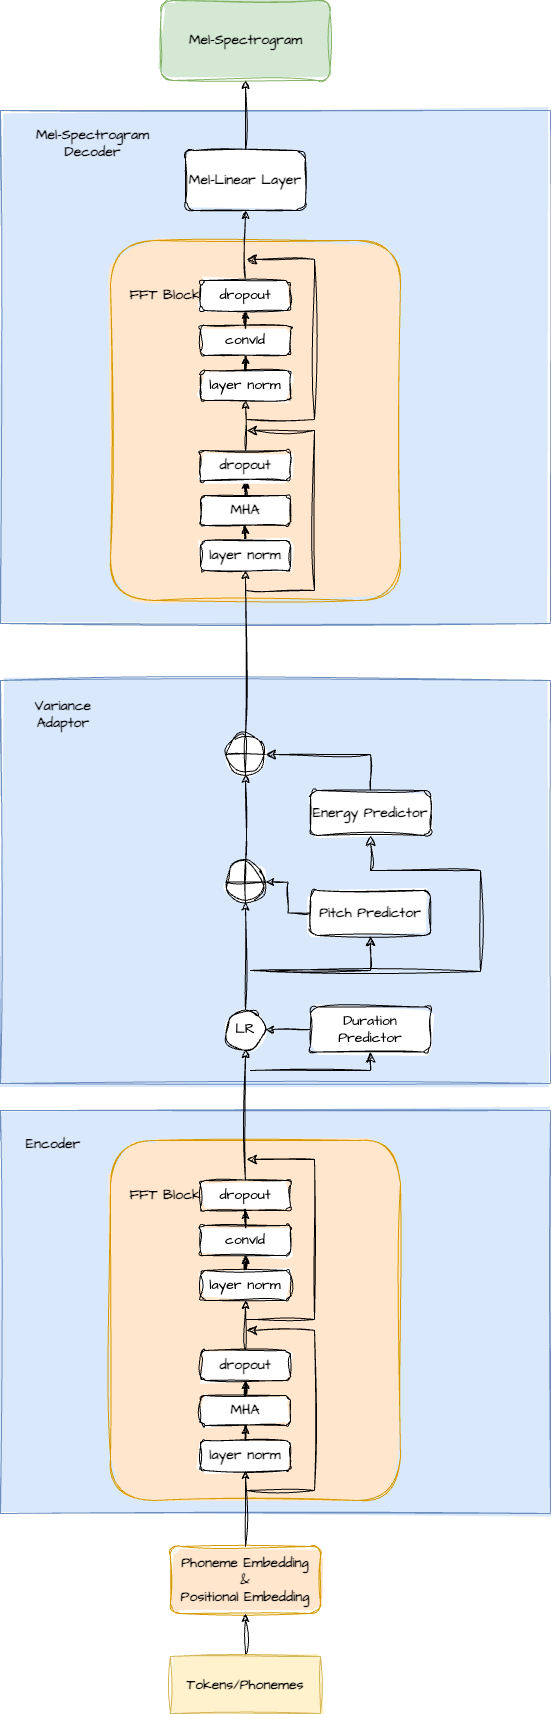

In [69]:
Image(filename = "../references/images/fastspeech2.drawio.png", width=500, height=500)

## Text2Mel

In [70]:
from audioml.fastspeech.model import Text2Mel

In [71]:
text2mel = Text2Mel(config)

In [ ]:
text_batch = feature_batch['raw_text']
input_ids = tokenizer.batch_tokenize(text_batch)

In [76]:
input_ids

{'input_ids': tensor([[ 0,  9, 31,  ...,  0,  0,  0],
         [ 0,  1, 32,  ...,  0,  0,  0],
         [ 0, 10, 56,  ...,  0,  0,  0],
         ...,
         [ 0,  7, 56,  ...,  0,  0,  0],
         [ 0,  4, 50,  ...,  0,  0,  0],
         [ 0, 70, 88,  ..., 15, 98,  0]]),
 'mask_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)}

In [87]:
# Inference Arguments: input_ids, src_mask, Optional: alpha (regulates speech of speech)
# Training Arguments: input_ids, src_mask, alpha, train, gt_duration

# text2mel_output = text2mel(input_ids['input_ids'], input_ids['mask_ids'])
text2mel_output = text2mel(input_ids['input_ids'], input_ids['mask_ids'], train=True, gt_duration=feature_batch['duration'])

In [88]:
text2mel_output['mel_spec'].shape

torch.Size([8, 837, 128])